In this notebook we will try to follow the following paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1088682/pdf/PB010869.pdf


Instead of the other one... Since it does not seem to help. This paper goes a bit better in detail in how the model is really made up.( the Lotka-Volterra Cascade model), so we will be focusing on this.


In this model they also give a more detailed definition of the Lotka-Volterra cascade model:
For each pair (i,j) with i < j, i NEVER consumes j. While species j has a probability c/n of eating. ( here n= number of species, c= number of connections for species i of whom we evaluate the pij (i guess..) This is not explained!!.) This was something I did not did, I assumed that the probability of that the other may consume, was just comming from by saying it is a antagonistic reaction (which is probable), but since this paper is only about angtagonistic. 

Maybe c is still antagonistic since it is probability 1, if c=n. I find this weird, Why is is the chance normalised by n ? and what is de definition of c? 

Well atleast he talks about four distinc situattions that can happen. For each pair (i,j) (where i< j):

    i) Species j has a negatif effect on i, but species i no effect on j. p_ij<0 pji=0. This is called a recipient-controlled link or r-link
    ii) Species j has no effect on i, but i has a positief effect on j. p_ij=0 pji>0 (donor controlled links or s-links)
    iii) Species j has negatif effect on i, and species i has positif effect on j. p_ij<0 & p_ji>0 (consumer-victim or t-links) 
    iv) Neither species has an effect on each other. p_ij=0 & p_ji=0. 
    
So indeed this model only talks about antagonistic reaction (since no p_ij>0 & p_ij>0) is possible. But this cascade model also allows for the situation that one of the sides is not connected. Let's try to implement that. And let's also implement the that we really do it with probability.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
n=8 # Species
r=0.05 # Chance to have an r-link A_ij<0, A_ji=0 (where i<j)
s=0.05 # chance to have an s-link A_ij=0, A_ji>0
t=0.1 # chance to have an t-link A_ij<0, A_ji>0
p_arr=np.array([r,s,t,1-(r+s+t)])#Probability array
# let r=-1, s=-2 and t=-3 No link =0 and let +1 be for mutalistic reactions (later on)
v=np.array([-1,-2,-3,0])# Value to know what connection it is.

For every pair (i,j) We need to determine what kind of connection it is going to be. (namely) r,s,t nothing or m.
Btw, we don't count pairs twice (i,j)=(j,i).

For a Most general food web of N species. How many connections are there? First look at one species. It is connected to all other species. =N-1 connections (You can't connect to your self) This for every species, so we have N(N-1) connections. But we have now counted every connectance twice (remembre (i,j)=(j,i)). So we have N(N-1)/2 connections

Make an array of N(N-1)/2 long. In which every element represents a connection.
We can generate this now in 2 ways:

    1) We make it static. Aka the number of r,s,t-links is fixed and represents fills exactly the chance r,s,t. And then we shuffel to make the connections random again. 
    2) We generate it also really random, and we do it following the probability distributions on that connection 

In [3]:
# Method 1, generate the links staticly:
Pair_type_static=np.zeros(int(n*(n-1)/2)) # I know n*(n-1) by construction is even and so doing /2 is always an int. but the computer does not see it that way
n_p=(n*(n-1)/2*p_arr).astype(int)# Create an array that holds the expectation number, of eacht type of connection
# let r=-1, s=-2 and t=-3 No link =0 and let +1 be for mutalistic reactions (later on)
Pair_type_static[0:n_p[0]]=-1#r
Pair_type_static[n_p[0]:n_p[0]+n_p[1]]=-2#s
Pair_type_static[n_p[0]+n_p[1]:n_p[0]+n_p[1]+n_p[2]]=-3#t
# This codes Sets the correct amount of connections (can easily be checked by: TestArray=np.zeros(10);TestArray[0:2]=1;TestArray[2:4]=2)
Pair_type_static=np.random.permutation(Pair_type_static)# Shuffel to mimic that the


# Method 2, from a distribution
Pair_type_distr=np.random.choice(v,int(n*(n-1)/2),p=p_arr)

#Let's evaluate the numbers:
print(Pair_type_static[Pair_type_static==-3].size)
print(Pair_type_distr[Pair_type_distr==-3].size)

2
7


On sees that the number of t-type connection for Static is always the same while distr floats arround that number. 

In [4]:
#check stability
def IsStable(JacobianMatrix):
    EigVals=np.linalg.eigvals(JacobianMatrix)
    EigValsReal=EigVals.real # Only work with real elements
    if(EigValsReal[EigValsReal>0].size==0): # No elements are greater than 0
        return 1
    else:
        return 0

def Create_a(n,Cup):
    Clo=np.transpose(Cup)# Lower triangle connection (i>j)
    C=Cup+Clo# Symmetric connection
    #Create some array slicing, and rightaway also determine it's size
    Upper_r=Cup==-1;sUr=Upper_r[Upper_r==True].size
    Lower_s=Clo==-2;sLs=Lower_s[Lower_s==True].size
    Upper_t=Cup==-3;sUt=Upper_t[Upper_t==True].size
    Lower_t=Clo==-3;sLt=Lower_t[Lower_t==True].size
    m=C==1;sm=m[m==True].size
    
    # Create the random Coëfficients. 
    e=np.random.rand(sm)
    gt=np.random.rand(sLt)
    gs=np.random.rand(sLs)
    
    A=np.random.rand(n,n)
    A[C==0]=0 # Keep only the non negatif ones.
    ASum=np.sum(A,1)
    
    row_ind=np.indices((n,n))[0]# Row indices. We need this since we will use this to acces ASum. 
    # Also this is in nxn matrix which needs to be, since we need to array slices is, which are also nxn matrixes.
    # the result will be an array with the correspoding row indices of the elements. Then apply this to ASum. 
    
    a=np.zeros((n,n))
    #First antagonistic
    # t
    a[Upper_t]=A[Upper_t]/ASum[row_ind[Upper_t]]
    a+=np.transpose(a)# Symetrise it. Because of this step, we need t first, since now it is still empty.
    a[Lower_t]*=gt # This should acces the term we just transposed there.
    a[Upper_t]*=-1 #Still make the upper negatif
    # r
    a[Upper_r]=-1*A[Upper_r]/ASum[row_ind[Upper_r]]
    # s
    a[Lower_s]=gs*A[Lower_s]/ASum[row_ind[Lower_s]]
    
    # Second Mutalistic reactions
    a[m]=e*A[m]/ASum[row_ind[m]]
    
    return a
    
def Stability(n,P,fm,fr,fs):
    samples=100
    stable=0
    for i in range(samples):
        #Create type for each connection
        p_arr=np.array([P*(1-fm)*fr,P*(1-fm)*fs,P*(1-fm)*(1-fr-fs),P*fm,1-P])# Chance distribution fo the connection type
        v=np.array([-1,-2,-3,1,0])# [r,s,t,m,nothing] This is the code that we will use in the C matrix.
        Pair_type=np.random.choice(v,int(n*(n-1)/2),p=p_arr)# Draw from the distriubtion of values=v determining the type of a connection, from a distriubtion P_arr.
        # Cast it in to matrix form
        Cup=np.zeros((n,n))
        Cup[np.triu_indices(n,1)]=Pair_type# upper triangle aka (i<j) (negatif for antagonistic)
        
        a=Create_a(n,Cup)
        
        X_fixed=np.random.rand(n)
        s=np.random.rand(n)
        J=np.dot(np.diag(X_fixed),a)+np.diag(-1*s*X_fixed)# first random is saturation, second is x_fixed
        if(IsStable(J)):
            stable+=1
    return stable/samples

VStability=np.vectorize(Stability,otypes=[float])

Time to compute: 2.3498829999999984 seconds


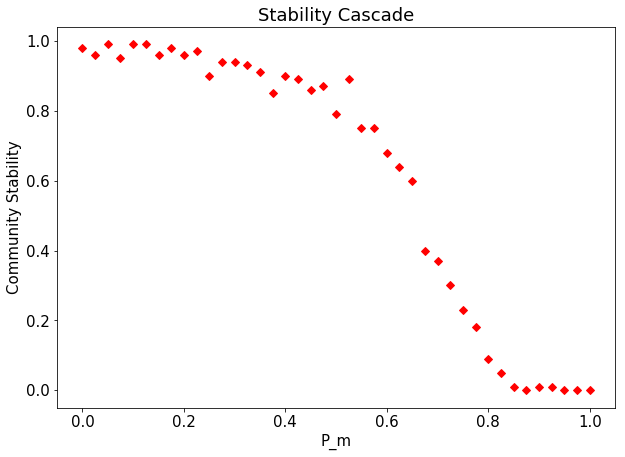

In [26]:
#Parameters
n=41 #Number of species
P=0.9# Connaction that maximum connectance
fm=np.linspace(0,1,41) # Fraction of the connections that is mutalism
fr=0.2# fraction of the antagonistic reactions that is r-type
fs=0.2# fraction of the antagonistic reactions that is s-type
# fr+fs<1 !! 

start=time.clock()
Stability=VStability(n,P,fm,fr,fs)
stop=time.clock()
print("Time to compute: "+str(stop-start)+" seconds")
#Graphics
#Generate the canvas
fig=plt.figure("PLOT",figsize=(10,7))
s=fig.add_subplot(111)

#Get the lables right
plt.title("Stability Cascade",fontsize = 18)
plt.xlabel('P_m',fontsize=15)
plt.ylabel('Community Stability',fontsize=15)
plt.tick_params(axis='both', labelsize=15)

#Plot the Graph
plt.plot(fm,Stability,'rD')

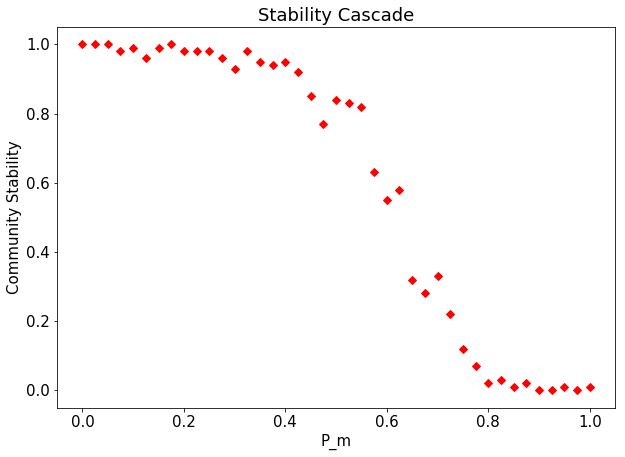

In [10]:
#Graphics
#Generate the canvas
fig=plt.figure("PLOT",figsize=(10,7))
s=fig.add_subplot(111)

#Get the lables right
plt.title("Stability Cascade",fontsize = 18)
plt.xlabel('P_m',fontsize=15)
plt.ylabel('Community Stability',fontsize=15)
plt.tick_params(axis='both', labelsize=15)

#Plot the Graph
plt.plot(fm,Stability,'rD')